In [1]:
from IPython import get_ipython
import warnings
warnings.filterwarnings("ignore")
ipython = get_ipython()


In [22]:
import torch
import random
import numpy as np

torch.manual_seed(200)
random.seed(200)
np.random.seed(200)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision import datasets, transforms, models

In [3]:
from google.colab import files
uploaded = files.upload()

Saving pathologyData.zip to pathologyData.zip


In [4]:
import zipfile
import io
pathologydata = zipfile.ZipFile(io.BytesIO(uploaded['pathologyData.zip']), 'r')
pathologydata.extractall()

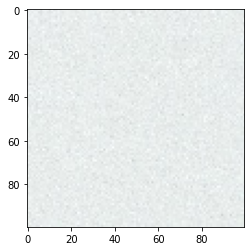

In [5]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('cancerData/background/1.jpg')
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

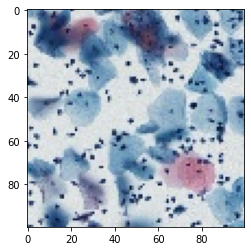

In [7]:
img1 = cv2.imread('cancerData/foreground/1.jpg')
img1_cvt=cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1_cvt)
plt.show()

In [8]:
import os
os.makedirs('output')

In [9]:
pip install split-folders

In [10]:
import splitfolders 
#### input dataset that want to split
input_folder = 'cancerData'  

output_folder= 'output'

splitfolders.ratio(input_folder, output= output_folder, seed=1337, ratio = (0.75,0.25))

Copying files: 3000 files [00:00, 5689.38 files/s]


In [11]:
!pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-ciuadcb8
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-ciuadcb8
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4990 sha256=587f5f1491b38b4111c902891478883bd0ad8e34f972558694e15a7bbd54bac4
  Stored in directory: /tmp/pip-ephem-wheel-cache-7l0v6h_a/wheels/69/06/fd/652908d49c931cdcca96be3c727fb11ed777a3a62402210396
Successfully built torchviz


In [12]:
transforms = transforms.Compose([
    transforms.ToTensor(),
transforms.Normalize((0,0,0), (1,1,1))])

In [13]:
from torch.utils.data.dataset import Dataset
trainset = torchvision.datasets.ImageFolder(root='output/train', transform = transforms)
dataloader_train = DataLoader(trainset, batch_size=100, shuffle=True)
testset = torchvision.datasets.ImageFolder(root='output/val', transform = transforms)
dataloader_test = DataLoader(testset, batch_size=100, shuffle=True)

In [14]:
print("[INFO] training dataset contains {} samples...".format(
        len(trainset)))
print("[INFO] validation dataset contains {} samples...".format(
        len(testset)))
print(trainset[30])

[INFO] training dataset contains 2250 samples...
[INFO] validation dataset contains 750 samples...
(tensor([[[0.8824, 0.8706, 0.8706,  ..., 0.8745, 0.8745, 0.8706],
         [0.8627, 0.8667, 0.8745,  ..., 0.8863, 0.8824, 0.8784],
         [0.8706, 0.8745, 0.8784,  ..., 0.8863, 0.8902, 0.8824],
         ...,
         [0.8863, 0.8941, 0.8863,  ..., 0.8980, 0.8863, 0.8941],
         [0.8745, 0.8902, 0.8824,  ..., 0.8784, 0.8667, 0.8706],
         [0.8784, 0.8980, 0.8902,  ..., 0.8902, 0.8745, 0.8824]],

        [[0.8824, 0.8706, 0.8706,  ..., 0.8784, 0.8784, 0.8745],
         [0.8627, 0.8667, 0.8745,  ..., 0.8902, 0.8863, 0.8824],
         [0.8706, 0.8745, 0.8784,  ..., 0.8902, 0.8941, 0.8863],
         ...,
         [0.8863, 0.8941, 0.8863,  ..., 0.9020, 0.8902, 0.8980],
         [0.8745, 0.8902, 0.8824,  ..., 0.8824, 0.8706, 0.8745],
         [0.8784, 0.8980, 0.8902,  ..., 0.8941, 0.8784, 0.8863]],

        [[0.8902, 0.8784, 0.8784,  ..., 0.8863, 0.8863, 0.8824],
         [0.8706, 0.874

We now create a CNN class, which has to be a subclass of `torch.nn.Module` and have its own `__init__` and `forward` functions. 

We choose a simple architecture with `2 convolutional blocks` followed by `2 fully connected blocks`.


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=5000, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)
torch.Size([100, 3, 100, 100]) torch.Size([100]) torch.Size([100, 2])


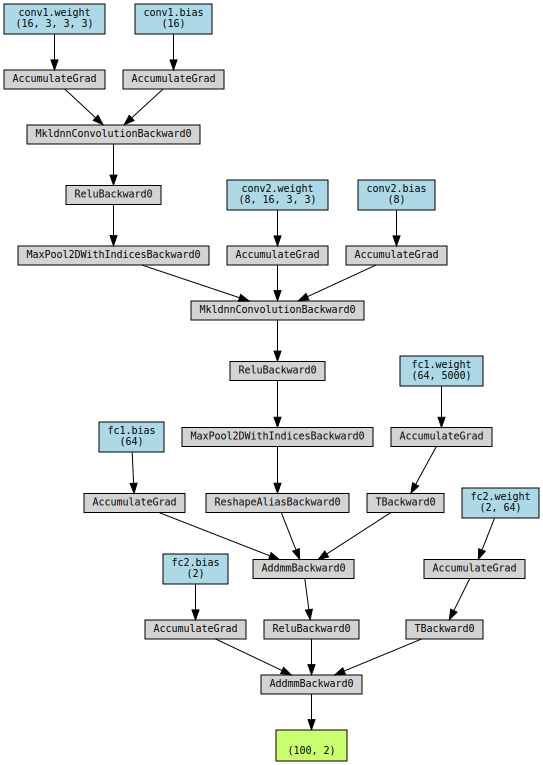

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # nn.Conv2d API : torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1,padding=1)  # 16 filters of 3x3 size and depth 3 (since input channel = 3)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3,padding =1,stride=1) # 32 filters of 3x3 size and depth 32
        self.fc1 = nn.Linear(25*25*8, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        # BLOCK 1: CONV + RELU +MAXPOOL
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        # BLOCK 2: CONV + RELU + MAXPOOL
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        # FLATTEN
        x = x.flatten(start_dim=1)
        # BLOCK 4: FC + RELU
        x = F.relu(self.fc1(x))
        # BLOCK 5: FC
        x = self.fc2(x)
        return x

model = CNN()
print(model)

# get a random training batch
iterator = iter(dataloader_train)
X_batch, y_batch = next(iterator)
print(X_batch.shape, y_batch.shape, model(X_batch).shape)

# pass a batch through the model and visualize the architecture
# NOTE: we do not have to explicitly call model.forward(inputs), instead we just do model(inputs)
# This is because PyTorch internally takes care of, giving us this syntactic sugar
make_dot(model(X_batch), params=dict(model.named_parameters()))

For training, we iterate over the datalaoder to get batches, and for each batch we do the following: 

- move each batch onto the specified device
- perform a forward pass through the model to get the outputs
- compute the loss based on the outputs and targets
- compute the gradients via backpropagation
- update the weights via the optimizer

In [16]:
def train(model, device, data_loader, optimizer, criterion, epoch):
    model.train()
    loss_train = 0
    num_correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
        prediction = output.argmax(dim=1)
        num_correct += prediction.eq(target).sum().item()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tAccuracy: {:.0f}%'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss_train / (batch_idx + 1),
                100. * num_correct / (len(data) * (batch_idx + 1))))
    loss_train /= len(data_loader)
    accuracy = num_correct / len(data_loader.dataset)
    return loss_train, accuracy
    

def test(model, device, data_loader, criterion):
    model.eval()
    loss_test = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            loss_test += loss.item()  # sum up batch loss
            prediction = output.argmax(dim=1)
            num_correct += prediction.eq(target).sum().item()
    loss_test /= len(data_loader)
    accuracy = num_correct / len(data_loader.dataset)
    return loss_test, accuracy

Now we put it all together:

- Create the model
- Set up the loss function (cross entropy)
- Add an optimizer (in this case, Adam)

In [25]:
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.008, betas=(0.9,0.999))

for epoch in range(1, 25):
    loss_train, acc_train = train(model, device, dataloader_train, optimizer, criterion, epoch)
    print('Epoch {} Train: Loss: {:.4f}, Accuracy: {:.3f}%\n'.format(
        epoch, loss_train, 100. * acc_train))
    loss_test, acc_test = test(model, device, dataloader_test, criterion)
    print('Epoch {} Test : Loss: {:.4f}, Accuracy: {:.3f}%\n'.format(
        epoch, loss_test, 100. * acc_test))

Train Epoch: 1 [0/2250 (0%)]	Loss: 0.6928	Accuracy: 49%
Epoch 1 Train: Loss: 0.8646, Accuracy: 54.844%

Epoch 1 Test : Loss: 0.6868, Accuracy: 54.400%

Train Epoch: 2 [0/2250 (0%)]	Loss: 0.6878	Accuracy: 55%
Epoch 2 Train: Loss: 0.9021, Accuracy: 56.356%

Epoch 2 Test : Loss: 0.7073, Accuracy: 50.000%

Train Epoch: 3 [0/2250 (0%)]	Loss: 0.7061	Accuracy: 50%
Epoch 3 Train: Loss: 0.6977, Accuracy: 50.622%

Epoch 3 Test : Loss: 0.6903, Accuracy: 56.133%

Train Epoch: 4 [0/2250 (0%)]	Loss: 0.6902	Accuracy: 61%
Epoch 4 Train: Loss: 0.6628, Accuracy: 50.578%

Epoch 4 Test : Loss: 0.6369, Accuracy: 50.400%

Train Epoch: 5 [0/2250 (0%)]	Loss: 0.6054	Accuracy: 57%
Epoch 5 Train: Loss: 0.4603, Accuracy: 86.578%

Epoch 5 Test : Loss: 0.3499, Accuracy: 94.133%

Train Epoch: 6 [0/2250 (0%)]	Loss: 0.3341	Accuracy: 93%
Epoch 6 Train: Loss: 0.3675, Accuracy: 91.733%

Epoch 6 Test : Loss: 0.3018, Accuracy: 92.400%

Train Epoch: 7 [0/2250 (0%)]	Loss: 0.2537	Accuracy: 92%
Epoch 7 Train: Loss: 0.2522, Acc